# Trening modelu DL

In [9]:
import pandas as pd
import numpy as np

import os.path as path
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf





In [10]:
# jeśli nie masz wsparcia gpu w tensorflow to wykomentuj dwie poniższe linie
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## 1.0 wczytanie przygotowanych danych

In [2]:
#ścieżka do folderu, gdzie trzymamy zapisane pliki po preporcessingu danych 
rel_path = 'data'

x_train = np.load(path.join(rel_path,'x_train.npy'))
x_test = np.load(path.join(rel_path,'x_test.npy'))
y_train = np.load(path.join(rel_path,'y_train.npy'))
y_test = np.load(path.join(rel_path,'y_test.npy'))

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)


In [4]:
input_shape = x_train.shape[1:]
out_shape = y_train.shape[1]
print(input_shape)
print(out_shape)

(28, 28, 1)
24


## zaszumienie danych

In [5]:
# funkcja do wyświetlania serii zdjęć
def showImages(data, name):
    samplesNum = data.shape[0]
    f,a=plt.subplots(1,samplesNum,figsize=(20,4))
    for i in range(samplesNum):
        a[i].matshow(data[i], cmap=cm.gray)
        a[i].axis('off')
    plt.suptitle(name)
    plt.show()

In [19]:
# funkcja zaszumiająca
def makeSomeNoise(images, noiseStrengh = 0.1):
    # pobieramy kształcałego zbioru do zaszumienia
    imgsShape = images.shape
    #print("imgs shape", imgsShape)
    # liczymy ile jest wszystkihc pikseli w zbiorze, do każdego osono coś dodamy
    pixelsNum = imgsShape[0]*imgsShape[1]*imgsShape[2]
    # generujemy szum i zmieniamy na kształ zbioru danych
    noise = np.random.normal(0,noiseStrengh,pixelsNum).reshape(imgsShape[0],imgsShape[1],imgsShape[2])
    # upewniamy się, że ilości się zgadzają
    #print("noise shape", noise.shape)
    # ostatecznie dodajemy szum do zdjęć
    imgsNoised = np.add(images, noise)
    return imgsNoised

In [17]:
x_train_img = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2])
x_test_img = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])

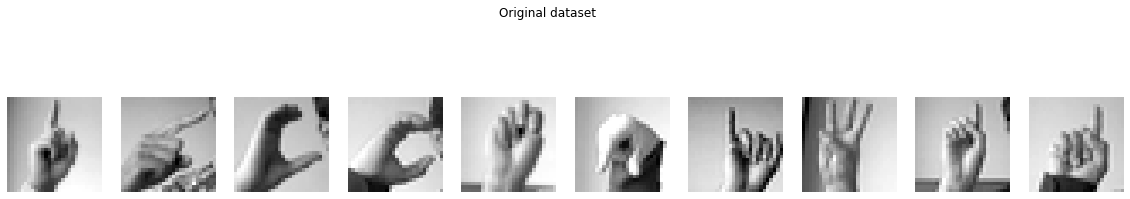

In [14]:
showImages(x_train_img[:10], "Original dataset")

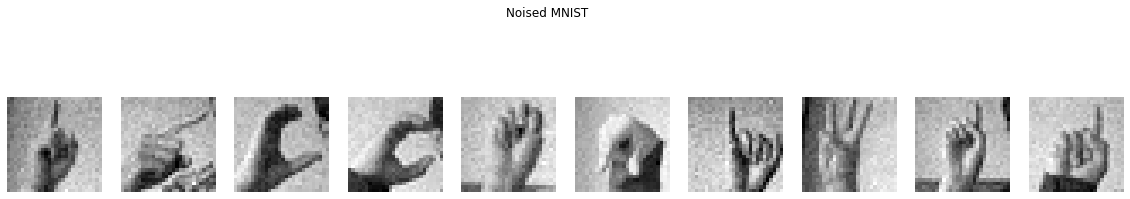

In [28]:
showImages(makeSomeNoise(x_train_img[:10], 0.03), "Noised MNIST")

In [32]:
# zaszumiamy cały dataset i od razu dodatkowy wymiar do sieci (nie chce mi sie już przerabiaż inputu)
x_train_noised = makeSomeNoise(x_train_img, 0.03).reshape(x_train.shape)
x_test_noised = makeSomeNoise(x_test_img, 0.03).reshape(x_test.shape)

In [33]:
print(x_train_noised.shape)
print(x_test_noised.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


# Przygotowanie modelu sieci

In [91]:
base_model = keras.Sequential()
base_model.add(keras.layers.Input(shape=(input_shape)))

base_model.add(keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'))
#base_model.add(keras.layers.BatchNormalization())
#base_model.add(keras.layers.Activation('relu'))
base_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


base_model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
#base_model.add(keras.layers.BatchNormalization())
#base_model.add(keras.layers.Activation('relu'))
base_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


base_model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
#base_model.add(keras.layers.BatchNormalization())
#base_model.add(keras.layers.Activation('relu'))
base_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

## maxpool to nie to samo co użycie STRIDES w konwolucji - pamiętać!!

base_model.add(keras.layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors


base_model.add(keras.layers.Dense(units=128,activation='relu'))
base_model.add(keras.layers.Dropout(0.55))

base_model.add(keras.layers.Dense(units=64,activation='relu'))
base_model.add(keras.layers.Dropout(0.55))

# base_model.add(keras.layers.Dense(units=32,activation='relu'))
# base_model.add(keras.layers.Dropout(0.5))



base_model.add(keras.layers.Dense(out_shape, activation='softmax'))



base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 576)              

In [92]:
base_model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy']
                  )

In [93]:
_batch_size = 128
_epochs = 80
_validation_split = 0.0

if _validation_split == 0.0:
    _val_data = (x_test_noised,y_test)
else:
    _val_data = None

In [94]:
 #dodany early stopping 
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [95]:
history = base_model.fit(x_train_noised, y_train, epochs=_epochs, batch_size=_batch_size, validation_split = _validation_split, validation_data = _val_data,
                        callbacks = [es_callback]
                        )

# od biedy można sobie zapisać "co któryś model", żeby łatwo z niego skorzystać

Train on 27455 samples, validate on 7172 samples
Epoch 1/80
27455/27455 [==============================] - 4s 140us/sample - loss: 2.9955 - accuracy: 0.0958 - val_loss: 2.0772 - val_accuracy: 0.3903
Epoch 2/80
27455/27455 [==============================] - 3s 107us/sample - loss: 1.7524 - accuracy: 0.4111 - val_loss: 0.9129 - val_accuracy: 0.7213
Epoch 3/80
27455/27455 [==============================] - 3s 108us/sample - loss: 1.0987 - accuracy: 0.6098 - val_loss: 0.6018 - val_accuracy: 0.8069
Epoch 4/80
27455/27455 [==============================] - 3s 107us/sample - loss: 0.8052 - accuracy: 0.7101 - val_loss: 0.4191 - val_accuracy: 0.8712
Epoch 5/80
27455/27455 [==============================] - 3s 107us/sample - loss: 0.6332 - accuracy: 0.7744 - val_loss: 0.3446 - val_accuracy: 0.9099
Epoch 6/80
27455/27455 [==============================] - 3s 107us/sample - loss: 0.5213 - accuracy: 0.8148 - val_loss: 0.2745 - val_accuracy: 0.9289
Epoch 7/80
27455/27455 [===========================

Epoch 55/80
27455/27455 [==============================] - 3s 110us/sample - loss: 0.0647 - accuracy: 0.9780 - val_loss: 0.1867 - val_accuracy: 0.9677
Epoch 56/80
27455/27455 [==============================] - 3s 110us/sample - loss: 0.0678 - accuracy: 0.9775 - val_loss: 0.2033 - val_accuracy: 0.9686
Epoch 57/80
27455/27455 [==============================] - 3s 110us/sample - loss: 0.0671 - accuracy: 0.9780 - val_loss: 0.1854 - val_accuracy: 0.9650
Epoch 58/80
27455/27455 [==============================] - 3s 110us/sample - loss: 0.0720 - accuracy: 0.9758 - val_loss: 0.2121 - val_accuracy: 0.9647
Epoch 59/80
27455/27455 [==============================] - 3s 111us/sample - loss: 0.0673 - accuracy: 0.9775 - val_loss: 0.2081 - val_accuracy: 0.9677
Epoch 60/80
27455/27455 [==============================] - 3s 111us/sample - loss: 0.0652 - accuracy: 0.9788 - val_loss: 0.2432 - val_accuracy: 0.9639
Epoch 61/80
27455/27455 [==============================] - 3s 110us/sample - loss: 0.0713 - ac

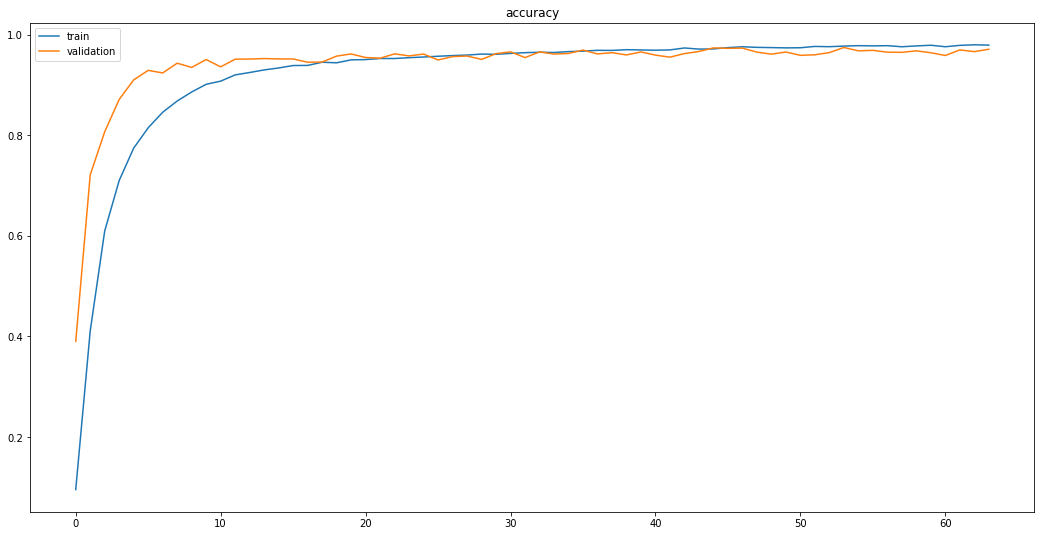

In [97]:
# rysowanie historii błędu
fig = plt.figure(figsize=(18,9))
#plt.plot(history.history['loss'])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["train", "validation"])

plt.title('accuracy')
plt.show()


# hasło do sprawdzenia - batch normalization

### sprawdziłem i wyszło, że jest gorzej... ładnie minimalizuje się loss trenigowy, ale walidacja "szarpie" - w końcowym modelu wyłączyłem toto

# poniżej sprawdzenie jak ta sieć radzi sobie na "zwykłych, niezaszumionych danych - radzi sobie równie dobrze, a czasem nawet lepiej

In [98]:
results1 = base_model.evaluate(x_test_noised, y_test, batch_size=len(x_test), verbose=0)
print("\n[!] Evaluation results on NOISED test data:")
print("{0}: {2:.3f}, {1}: {3:.3f}".format(*base_model.metrics_names, *results1))


[!] Evaluation results on NOISED test data:
loss: 0.181, accuracy: 0.971


In [99]:
results = base_model.evaluate(x_test, y_test, batch_size=len(x_test), verbose=0)
print("\n[!] Evaluation results on CLEAN test data:")
print("{0}: {2:.3f}, {1}: {3:.3f}".format(*base_model.metrics_names, *results))


[!] Evaluation results on CLEAN test data:
loss: 0.162, accuracy: 0.975


In [100]:
saved_file = 'trained_model_noised.h5'
base_model.save(saved_file)

In [102]:
loaded_model = keras.models.load_model(saved_file)

In [103]:
results = loaded_model.evaluate(x_test, y_test, batch_size=len(x_test), verbose=0)
print("\n[!] Evaluation results:")
print("{0}: {2:.3f}, {1}: {3:.3f}".format(*base_model.metrics_names, *results))


[!] Evaluation results:
loss: 0.162, accuracy: 0.975
